In [60]:
import pandas as pd
import numpy as np
import re
from kiwipiepy import Kiwi
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error





In [61]:
data = pd.read_csv('weaviate_data(임시).csv')
data.head(2)

,recipeID,recipe_name,summary,ingredient_name,full_step,category,image_link
0,0,우엉양배추볶음밥,찬밥이 기다려지는 우엉양배추볶음밥입니다.,[재료] 찬 밥 적당량 양배추 적당량 우엉 적당량 느타리버섯 조금 다시마 ...,찬밥을 준비해주세요. 양배추와 우엉을 준비해주시고 양배추는 깨끗히 씻어서 잘게 잘라...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...
1,1,아삭아삭 연근장아찌 만들기,연근은 비타민C와 식이섬유소가 풍부하고 빈혈예방에 탁월하고 코피가 자주나는 아이들에...,[재료] 연근 [양념비율(200ml 계량컵 기준)] 간장 1 물 1 설탕 0...,연근은 감자칼로 껍질을 벗겨주었어요. 슥슥 0.5mm정도 잘라주었답니다. 찬물에 식...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipeID         874 non-null    int64 
 1   recipe_name      874 non-null    object
 2   summary          835 non-null    object
 3   ingredient_name  842 non-null    object
 4   full_step        840 non-null    object
 5   category         874 non-null    object
 6   image_link       874 non-null    object
dtypes: int64(1), object(6)
memory usage: 47.9+ KB


In [63]:
source = []
for ingredient_name in data['ingredient_name']:
    ingredient_name_str = str(ingredient_name)
    if '양념' in ingredient_name_str:
        ingredient_matches = re.findall(r'\[.*?\](.*?)\양념', ingredient_name_str)
        source_per_ingredient = []
        for ingredient_match in ingredient_matches:
            ingredient_cleaned = re.sub(r'[0-9]+[가-힣]+', '', ingredient_match).strip().split()
            for ing in ingredient_cleaned:
                if ing:
                    ingredient_final = re.sub(r'[^가-힣\s]', '', ing).strip()
                    if ingredient_final:
                        source_per_ingredient.extend(ingredient_final.split())
    else:
        ingredient_matches = re.findall(r'\[.*?\](.*)', ingredient_name_str)
        source_per_ingredient = []
        for ingredient_match in ingredient_matches:
            ingredient_cleaned = re.sub(r'[0-9]+[가-힣]+', '', ingredient_match).strip().split()
            for ing in ingredient_cleaned:
                if ing:
                    ingredient_final = re.sub(r'[^가-힣\s]', '', ing).strip()
                    if ingredient_final:
                        source_per_ingredient.extend(ingredient_final.split())
    # if source_per_ingredient:
    source.append(source_per_ingredient)

In [64]:
len(source)

874

In [65]:
sum(1 for item in source if not item)

32

In [66]:
data['main_source'] = source

In [67]:
data_re = pd.read_csv('user_review.csv')

C:\Users\SSO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


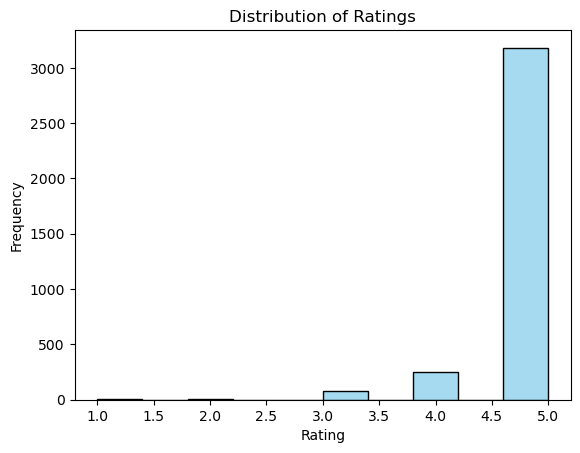

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터의 분포를 히스토그램으로 그리기
sns.histplot(data=data_re, x='rating', bins=10, color='skyblue', edgecolor='black')

# 그래프 제목과 축 레이블 추가
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

In [69]:
data_re.head(1)

,recipe_name,user_id,posting_time,rating,review_content,category,recipeID,reviewID
0,아삭아삭 연근장아찌 만들기,ronaldo115,2017-06-08 17:52:21,5,연근조림 정말 맛있어요!\n꼭 다이어트해서 설현 몸매가 될거에요 ㅎㅎㅎ,저칼로리 다이어트,1,3341


In [70]:
data.head(1)

,recipeID,recipe_name,summary,ingredient_name,full_step,category,image_link,main_source
0,0,우엉양배추볶음밥,찬밥이 기다려지는 우엉양배추볶음밥입니다.,[재료] 찬 밥 적당량 양배추 적당량 우엉 적당량 느타리버섯 조금 다시마 ...,찬밥을 준비해주세요. 양배추와 우엉을 준비해주시고 양배추는 깨끗히 씻어서 잘게 잘라...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[찬, 밥, 적당량, 양배추, 적당량, 우엉, 적당량, 느타리버섯, 조금, 다시마,..."


In [71]:
data_re = data_re[data_re['rating'] >= 4]

In [72]:
data_re.duplicated().sum()

0

In [73]:
df = pd.merge(data, data_re, on=['recipeID', 'recipe_name', 'category'], how='outer')

In [74]:
df.loc[df['user_id'].isna()]

,recipeID,recipe_name,summary,ingredient_name,full_step,category,image_link,main_source,user_id,posting_time,rating,review_content,reviewID
0,0,우엉양배추볶음밥,찬밥이 기다려지는 우엉양배추볶음밥입니다.,[재료] 찬 밥 적당량 양배추 적당량 우엉 적당량 느타리버섯 조금 다시마 ...,찬밥을 준비해주세요. 양배추와 우엉을 준비해주시고 양배추는 깨끗히 씻어서 잘게 잘라...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[찬, 밥, 적당량, 양배추, 적당량, 우엉, 적당량, 느타리버섯, 조금, 다시마,...",NaN,NaN,NaN,NaN,NaN
4,3,아보카도 멜론 냉수프 만들기,만들기 간단하고 맛이 고급스러운 멜론 냉수프,[재료] 아보카도 1/4개 멜론 1/4개 우유(농도 조절용으로) 약간,"잘 익은 멜론과 아보카도, 우유를 준비해 주세요. 우유는 농도 조절용으로 사용하셔도...",저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[아보카도, 멜론, 우유농도, 조절용으로, 약간]",NaN,NaN,NaN,NaN,NaN
6,5,다이어트식 도토리묵 무침,"다이어트식, 반찬, 안주로도 좋은 도토리묵무침 레시피",[재료] 도토리묵 250g 구운김 1+1/2장 [양념] 간장 2큰술 맛술 1...,김은 바삭하게 구워 비닐봉투에 넣어 마구마구 부셔주세요. 도토리묵은 먹기좋게 썰어주...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[도토리묵, 구운김]",NaN,NaN,NaN,NaN,NaN
7,6,열량줄인 다이어트 김밥,제목처럼 다이어트 김밥이에요. 현미와 검정콩 섞은 밥에 채소를 듬뿍 넣고 닭가슴살을...,[재료] 채소 닭가슴살 [양념] 들기름,"뒷줄 왼쪽 붉은 색이 도는 다홍채와 케일잎, 오른쪽이 생채. 채소류는 유기농으로 깨...",저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[채소, 닭가슴살]",NaN,NaN,NaN,NaN,NaN
8,7,"파프리카 샐러드, 파프리카 다이어트","채소 중에 가장 식감이 좋다는 빨강과 노랑, 주황의 파프리카로 만든 단맛과 아삭함이...",[재료] 빨강파프리카 노랑파프리카 말린버섯 약간 적양파(소) 1개 토마토 ...,채소는 씻어 준비하고요. 말린 버섯도 먹을 양만큼 씻어 주세요. 말린 버섯은 쫄깃해...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[빨강파프리카, 노랑파프리카, 말린버섯, 약간, 적양파소, 토마토, 식초, 약간, ...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3807,864,[블루밍어니언] 양파꽃이 피었습니다 블루밍어니언 만들기 양파튀김 만들어볼까요 -양싸,친구가 인터넷에서 봤다면서\r\n꽃모양 양파튀김이 있대요 그게 먹고싶다고\r\n주문...,[재료] 양파 큰거 1개 계란 2개 우유 500ml [양념] 튀김가루 고추가...,양파는 큰거로 준비해주세요깨끗이 씻으세요 그리고 완전히 자르지 마시고끝쪽에 살짝 남...,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[양파, 큰거, 계란, 우유]",NaN,NaN,NaN,NaN,NaN
3830,866,현미 잣죽,영양가득한 부드러운 잣죽입니다.,[재료] 불린 현미 1/2컵 (또는 백미) 잣 50g 물 5~6컵 [양념] 소금,불린 현미와 물 한컵을 넣고 갈아주고 잣은 잠깐 물에 담궜다가 물 한컵을 넣고 갈아...,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[불린, 현미, 또는, 백미, 잣, 물]",NaN,NaN,NaN,NaN,NaN
3831,867,잣콩국수,"간단하게 만들어 먹을 수 있는 여름 별미, 고소함이 가득한 잣콩국수입니다.",[재료] 잣 5큰술 우유 500ml 두부 1/2모 소금 약간 오이 약간 삶...,잣은 마른팬에 살짝 볶아주시고 믹서기에 볶은 잣을 넣어주세요. 잣을 넣은 믹서기에 ...,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[잣, 우유, 두부, 소금, 약간, 오이, 약간, 삶은, 달걀]",NaN,NaN,NaN,NaN,NaN
3933,871,참치깻잎밥전&참치깻잎치즈밥전,비오는날은 전이 생각나잖아요 오늘은 향긋한 깻잎과 참치와 밥을 섞어 다른반찬 필요없...,[재료] 밥 1공기 네모참치 1캔 빨강파프리카 1개 깻잎 20장 달걀 2개 ...,"네모참치,깻잎,파프리카 준비해주시고 깻잎,파프리카 잘게 썰어주세요. 참치캔은 기름기...",치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[밥, 네모참치, 빨강파프리카, 깻잎, 달걀, 기름, 적당량, 슬라이스치즈]",NaN,NaN,NaN,NaN,NaN


In [75]:
kiwi = Kiwi()
stop_words = ['물', '약간', '적당', '적당량', '조금', '때', '레시피', '요리', '거', '수', ]

def extract_keywords(text):
    keywords = []
    text = text.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    for title in text:
        titles = []
        result = kiwi.analyze(title)
        for token, tag, _ , _ in result[0][0]:
            if tag[0] in 'NN':
                if token not in stop_words:
                    titles.append(token)
        keywords.append(titles)
    return keywords

In [76]:
name = extract_keywords(df['recipe_name'].apply(str))
summary = extract_keywords(df['summary'].apply(str))
source = extract_keywords(df['main_source'].apply(str))

In [77]:
review = extract_keywords(df['review_content'].apply(str))


In [78]:
list_all = []

for item_1, item_2, item_3, item_4 in zip(name, summary, source, review):
    combined_list = item_1 + item_2 + item_3 + item_4
    list_all.append(combined_list)

In [79]:
df['all'] = list_all

In [80]:
all_keyword = []
for i in df['all']:
    for item in i:
        all_keyword.append(item)
print(len(all_keyword))

86547


In [81]:
unique_keyword = set(all_keyword)
print(len(unique_keyword))


3520


In [82]:
'우엉' in unique_keyword

True

In [83]:
total_recipe_count = len(set(data['recipe_name']))
keyword_count_dict = dict.fromkeys(unique_keyword)

for keyword_list in df['all']:
    for keyword in keyword_list:
        if keyword_count_dict[keyword.strip()] == None:
            keyword_count_dict[keyword.strip()] = 1
        else:
            keyword_count_dict[keyword.strip()] += 1

In [84]:
keyword_idf = dict()
for each_keyword in keyword_count_dict:
    keyword_idf[each_keyword] = np.log10(total_recipe_count/keyword_count_dict[each_keyword])

In [85]:
sorted_data_dict = dict(sorted(keyword_idf.items(), key=lambda item: item[1], reverse=True))

In [86]:
all_category = data['category'].explode().tolist()
all_keyword = df['all'].explode().tolist()
unique_keyword = set(all_keyword)
unique_category = set(all_category)

In [87]:
unique_category

{'간 건강',
 '골다공증',
 '노화방지',
 '머슬업 다이어트',
 '변비',
 '스트레스 해소',
 '암 예방',
 '위 건강',
 '장 건강',
 '저칼로리 다이어트',
 '치매예방',
 '피로회복',
 '혈당조절',
 '혈액순환',
 '호흡기 건강'}

In [117]:
# 카테고리별 단어집합
for index, cat in enumerate(unique_category):
    globals()['df_{}'.format(index)] = df.loc[df['category'] == cat, 'all']
    
    # 해당 카테고리에 대한 키워드 카운트 딕셔너리 초기화
    globals()['keyword_count_dict_df_{}'.format(index)] = dict.fromkeys(unique_keyword, 0)
    
    # 해당 카테고리의 데이터에서 키워드 카운트 진행
    for keyword_list in globals()['df_{}'.format(index)]:
        for keyword in keyword_list:
            globals()['keyword_count_dict_df_{}'.format(index)][keyword_idf.strip()] += 1
    globals()['keyword_count_dict_df_{}'.format(index)] = dict(sorted(globals()['keyword_count_dict_df_{}'.format(index)].items(), key=lambda item: item[1], reverse=True))

In [136]:
keyword_count_dict_df_5

{'깻잎': 429,
 '두부': 399,
 '맛': 309,
 '김치': 265,
 '부침': 259,
 '양파': 239,
 '강정': 186,
 '황금': 166,
 '일품': 166,
 '거': 147,
 '청국장찌개': 142,
 '애호박': 133,
 '당근': 113,
 '입맛': 105,
 '감사': 103,
 '장': 101,
 '향': 100,
 '입': 98,
 '아몬드': 97,
 '중': 96,
 '견과': 95,
 '조림': 95,
 '하나': 95,
 '치킨': 94,
 '손': 94,
 '변신': 93,
 '호두': 93,
 '슬라이스': 93,
 '고급': 93,
 '후회': 93,
 '안': 93,
 '마트': 92,
 '품목': 92,
 '의식': 92,
 '전': 87,
 '청국장': 83,
 '명절': 75,
 '밥도둑': 74,
 '쌀뜨물': 73,
 '소금': 58,
 '볶음': 53,
 '계란': 45,
 '홍고추': 45,
 '밀가루': 41,
 '저': 41,
 '식용유': 38,
 '밥': 35,
 '시금치': 33,
 '양념': 32,
 '고민': 32,
 '새우': 30,
 '것': 28,
 '수': 27,
 '간단': 26,
 '반찬': 24,
 '나물': 24,
 '뭐': 24,
 '대파': 23,
 '참깨': 22,
 '눈': 22,
 '한참': 22,
 '반찬거리': 22,
 '설탕': 21,
 '법': 19,
 '번': 19,
 '가루': 18,
 '간장': 18,
 '최고': 17,
 '들기름': 17,
 '버터': 17,
 '연어': 17,
 '덕분': 16,
 '소개': 15,
 '블루베리': 15,
 '신랑': 14,
 '겉절이': 14,
 '우유': 14,
 '딸': 14,
 '아이': 14,
 '카레': 13,
 '멸치': 13,
 '통깨': 13,
 '반': 12,
 '달걀': 12,
 '덮밥': 12,
 '처음': 12,
 '음식': 11,
 '석류': 11,
 '오늘': 11,
 '굿

In [129]:
import math
for index, cat in enumerate(unique_category):
    globals()['df_{}'.format(index)] = df.loc[df['category'] == cat, 'all']
    globals()['keyword_idf_dict_df_{}'.format(index)] = dict.fromkeys(unique_keyword, 0)

    for keyword_list in globals()['df_{}'.format(index)]:
        for keyword in set(keyword_list):  # 중복된 키워드는 한 번만 고려합니다.
            globals()['keyword_idf_dict_df_{}'.format(index)][keyword.strip()] += 1
    
    # IDF 값 계산
    for keyword, count in globals()['keyword_idf_dict_df_{}'.format(index)].items():
        if count > 0:
            globals()['keyword_idf_dict_df_{}'.format(index)][keyword] = math.log(total_recipe_count / count)
        else:
            globals()['keyword_idf_dict_df_{}'.format(index)][keyword] = 0
            
    # IDF 값을 기준으로 딕셔너리 정렬
    globals()['keyword_idf_dict_df_{}'.format(index)] = dict(sorted(globals()['keyword_idf_dict_df_{}'.format(index)].items(), key=lambda item: item[1], reverse=True))

In [135]:
keyword_idf_dict_df_5

{'색깔': 6.6895992691789665,
 '신경': 6.6895992691789665,
 '채반': 6.6895992691789665,
 '햄버거': 6.6895992691789665,
 '마무리': 6.6895992691789665,
 '청양초': 6.6895992691789665,
 '노력': 6.6895992691789665,
 '굴': 6.6895992691789665,
 '암송': 6.6895992691789665,
 '보고': 6.6895992691789665,
 '보관': 6.6895992691789665,
 '접시': 6.6895992691789665,
 '바다': 6.6895992691789665,
 '레서피': 6.6895992691789665,
 '정성': 6.6895992691789665,
 '곳': 6.6895992691789665,
 '추천': 6.6895992691789665,
 '과일': 6.6895992691789665,
 '줌': 6.6895992691789665,
 '키친타올': 6.6895992691789665,
 '속': 6.6895992691789665,
 '죽': 6.6895992691789665,
 '장아찌': 6.6895992691789665,
 '수정': 6.6895992691789665,
 '액': 6.6895992691789665,
 '생선': 6.6895992691789665,
 '거품': 6.6895992691789665,
 '요번': 6.6895992691789665,
 '향기': 6.6895992691789665,
 '숙주': 6.6895992691789665,
 '식탁': 6.6895992691789665,
 '치맥': 6.6895992691789665,
 '얼음': 6.6895992691789665,
 '젓': 6.6895992691789665,
 '패스': 6.6895992691789665,
 '앞': 6.6895992691789665,
 '콩쪼림': 6.6895992691789665,
 

## category 별 데이터프레임

In [88]:
category_representation = pd.DataFrame(columns=sorted(unique_category), index=df['recipeID'])
print(category_representation.head(1))

         간 건강 골다공증 노화방지 머슬업 다이어트   변비 스트레스 해소 암 예방 위 건강 장 건강 저칼로리 다이어트 치매예방  \
recipeID                                                                      
0         NaN  NaN  NaN      NaN  NaN     NaN  NaN  NaN  NaN       NaN  NaN   

         피로회복 혈당조절 혈액순환 호흡기 건강  
recipeID                        
0         NaN  NaN  NaN    NaN  


In [89]:
for category in df['category']:
    # 해당하는 카테고리에는 1을 넣고 아니면 0을 넣음
    category_representation[category] = np.where(df['category'] == category, 2, None)

In [90]:
print(category_representation.tail(5))

          간 건강  골다공증  노화방지 머슬업 다이어트    변비 스트레스 해소  암 예방  위 건강  장 건강 저칼로리 다이어트  \
recipeID                                                                        
872       None  None  None     None  None    None  None  None  None      None   
872       None  None  None     None  None    None  None  None  None      None   
872       None  None  None     None  None    None  None  None  None      None   
872       None  None  None     None  None    None  None  None  None      None   
873       None  None  None     None  None    None  None  None  None      None   

         치매예방  피로회복  혈당조절  혈액순환 호흡기 건강  
recipeID                                
872         2  None  None  None   None  
872         2  None  None  None   None  
872         2  None  None  None   None  
872         2  None  None  None   None  
873         2  None  None  None   None  


## keyword 별 데이터프레임

In [91]:
keyword_representation = pd.DataFrame(columns=sorted(unique_keyword), index=df['recipeID'])
print(keyword_representation.head(1))

            -  -말캉    . .꽁치캔   .맜  .무우  .알탕  .양뇸  2손다  3스픈  ...   흥미   희망  \
recipeID                                                    ...             
0         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

           흰색   흰자 흰후추가루    히   히트   힌트   힐링    힘  
recipeID                                           
0         NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  

[1 rows x 3520 columns]


In [92]:
for index in tqdm(range(len(df['recipeID']))):
    keywords = df['all'][index]
    recipeID = df['recipeID'].iloc[index]
    for keyword in keywords:
        keyword_idf_value = keyword_idf.get(keyword.strip(), None) 
        if keyword_idf_value is not None:
            keyword_representation.at[recipeID, keyword] = keyword_idf_value

# keyword_representation.sort_index(inplace=True)

100%|█████████████████████████████████████████████████████████████████████████████| 3943/3943 [00:05<00:00, 684.50it/s]


In [93]:
keyword_representation.head(5)

,-,-말캉,.,.꽁치캔,.맜,.무우,.알탕,.양뇸,2손다,3스픈,...,흥미,희망,흰색,흰자,흰후추가루,히,히트,힌트,힐링,힘
recipeID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 카테고리 + 키워드

In [94]:
recipe_representation = pd.concat([category_representation, keyword_representation], axis=1).fillna(0)


In [95]:
recipe_representation = recipe_representation.drop_duplicates()
print(recipe_representation.shape)
print(recipe_representation.describe())

(871, 3535)
             간 건강        골다공증        노화방지    머슬업 다이어트          변비     스트레스 해소  \
count  871.000000  871.000000  871.000000  871.000000  871.000000  871.000000   
mean     0.137773    0.137773    0.133180    0.137773    0.130884    0.137773   
std      0.506813    0.506813    0.498908    0.506813    0.494893    0.506813   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      2.000000    2.000000    2.000000    2.000000    2.000000    2.000000   

             암 예방        위 건강        장 건강   저칼로리 다이어트  ...          흥미  \
count  871.000000  871.000000  871.000000  871.000000  ...  871.000000   
mean     0.126292    0.137773    0.140069    0.137773  ...    0.003336   
std      0.486730    0.506813    0.5

In [96]:
def cos_sim_matrix(a, b):
    cos_sim = cosine_similarity(a, b)
    result_df = pd.DataFrame(data=cos_sim, index=[a.index])
    
    return result_df

In [97]:
cs_df = cos_sim_matrix(recipe_representation, recipe_representation)
cs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,861,862,863,864,865,866,867,868,869,870
recipeID,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.100491,0.105704,0.133676,0.116322,0.161827,0.091519,0.126228,0.207185,0.083339,...,0.000000,0.000163,0.000000,0.000000,0.000000,0.000099,0.000000,0.000504,0.011214,0.000000
1,0.100491,1.000000,0.088277,0.114714,0.099822,0.142285,0.080219,0.139926,0.182167,0.071517,...,0.000148,0.028773,0.000000,0.000000,0.000000,0.001785,0.002541,0.000000,0.001876,0.000000
2,0.105704,0.088277,1.000000,0.139337,0.154810,0.142158,0.080147,0.110886,0.182004,0.073210,...,0.000000,0.000000,0.000000,0.012405,0.000000,0.011396,0.000000,0.019902,0.000000,0.000052
3,0.133676,0.114714,0.139337,1.000000,0.132785,0.179776,0.101355,0.140228,0.230165,0.095134,...,0.008689,0.001608,0.000000,0.017072,0.000000,0.000982,0.003160,0.000000,0.002333,0.000000
4,0.116322,0.099822,0.154810,0.132785,1.000000,0.156437,0.088197,0.139947,0.202403,0.082879,...,0.000941,0.001996,0.015134,0.000000,0.000262,0.021433,0.043520,0.000000,0.002809,0.000057


In [98]:
cs_df.shape

(871, 871)

In [99]:
print(cs_df[1].sort_values(ascending=False))

recipeID
1           1.000000
18          0.213459
750         0.183876
8           0.182167
28          0.166527
              ...   
579         0.000000
578         0.000000
577         0.000000
576         0.000000
873         0.000000
Name: 1, Length: 871, dtype: float64


In [100]:
print(data.loc[1])
print(data.loc[18])
print(data.loc[8])
print(data.loc[750])

recipeID                                                           1
recipe_name                                           아삭아삭 연근장아찌 만들기
summary            연근은 비타민C와 식이섬유소가 풍부하고 빈혈예방에 탁월하고 코피가 자주나는 아이들에...
ingredient_name    [재료] 연근  [양념비율(200ml 계량컵 기준)] 간장  1 물  1 설탕  0...
full_step          연근은 감자칼로 껍질을 벗겨주었어요. 슥슥 0.5mm정도 잘라주었답니다. 찬물에 식...
category                                                   저칼로리 다이어트
image_link         https://recipe1.ezmember.co.kr/cache/recipe/20...
main_source                                                     [연근]
Name: 1, dtype: object
recipeID                                                          18
recipe_name                                               양파 장아찌 만들기
summary                 제철에 담아두면 일 년 내내 맛있게 드실 수가 있어서 참 좋은 양파장아찌입니다.
ingredient_name                              [재료] 양파  간장  물  설탕  식초 
full_step          양파는 적당한 크기로 썰어 주세요. 양파 담아줬어요. 내열강화유리라 뜨거운 절임물 ...
category                                                   저칼로리 다이어트
image_link 

In [101]:
data_re.isnull().sum()

recipe_name       0
user_id           0
posting_time      0
rating            0
review_content    0
category          0
recipeID          0
reviewID          0
dtype: int64

In [102]:
train_df, test_df = train_test_split(data_re, test_size=0.2, random_state=1234)

In [103]:
test_userids = list(set(test_df.reviewID.values))
test_userids

[0,
 2,
 6,
 2055,
 2059,
 2064,
 2067,
 2070,
 24,
 2072,
 2074,
 2075,
 2078,
 33,
 37,
 2085,
 39,
 2087,
 42,
 2091,
 44,
 2093,
 49,
 2098,
 51,
 2097,
 56,
 57,
 59,
 2108,
 60,
 68,
 2119,
 74,
 77,
 2126,
 2128,
 83,
 88,
 93,
 96,
 98,
 2152,
 2153,
 107,
 108,
 2157,
 112,
 113,
 114,
 2164,
 118,
 2166,
 2171,
 127,
 128,
 2175,
 2178,
 2179,
 2180,
 135,
 136,
 137,
 138,
 2187,
 2186,
 2191,
 2196,
 148,
 2208,
 160,
 163,
 164,
 2215,
 167,
 168,
 172,
 175,
 176,
 2228,
 2229,
 2232,
 2233,
 2246,
 200,
 2249,
 204,
 2253,
 2256,
 2258,
 212,
 213,
 2262,
 220,
 2270,
 225,
 233,
 2283,
 238,
 2288,
 2289,
 2290,
 247,
 249,
 2302,
 255,
 2304,
 260,
 2313,
 267,
 269,
 275,
 277,
 2327,
 2331,
 2332,
 285,
 2334,
 2335,
 287,
 2337,
 290,
 2338,
 2339,
 294,
 308,
 2360,
 313,
 2364,
 317,
 2369,
 2371,
 326,
 2377,
 2378,
 2379,
 334,
 2385,
 2388,
 2389,
 2394,
 348,
 2397,
 2398,
 349,
 352,
 2403,
 356,
 2407,
 2409,
 363,
 2412,
 367,
 2416,
 2417,
 370,
 2419,
 37

In [104]:
result_df = pd.DataFrame()

for user_id in tqdm(test_userids):
    user_record_df = train_df.loc[train_df.reviewID == int(user_id), :]
    
    user_sim_df = cs_df.loc[user_record_df['recipeID']]
    user_rating_df = user_record_df[['rating']]
    
    # 가중치 계산
    sim_sum = np.sum(user_sim_df.T.to_numpy(), -1)     # 각 열의 값을 합산
    
    # user_sim_df.T.to_numpy() : 사용자 유사도를 행렬 형태로 나타내기 위한 준비 작업
    # user_rating_df.to_numpy() : 사용자 평가를 행렬 형태로 나타내기 위한 준비 작업
    # np.matmul : 사용자 유사도하고 사용자 평가 데이터 간의 행렬 곱셈을 수행, 사용자에 대한 가중 평가 합계를 얻기 위한 작업
    # / (sim_sum+1) : 유사도의 합이 0이 되는 것을 방지하기 위해 1을 더해서 나눠줌
    prediction = np.matmul(user_sim_df.T.to_numpy(), user_rating_df.to_numpy()).flatten() / (sim_sum+1)
  
    # 프린트 하는 과정
    prediction_df = pd.DataFrame(prediction, index=cs_df.index).reset_index()
    prediction_df.columns = ['recipeID', 'pred_rating']
    prediction_df = prediction_df[['recipeID', 'pred_rating']][prediction_df.recipeID.isin(test_df[test_df.reviewID == user_id]['recipeID'])]
    
    temp_df = prediction_df.merge(test_df[test_df.reviewID == user_id], on='recipeID')
    result_df = pd.concat([result_df, temp_df], axis=0)

100%|███████████████████████████████████████████████████████████████████████████████| 675/675 [00:03<00:00, 191.98it/s]


In [105]:
result_df.head(10)

,recipeID,pred_rating,recipe_name,user_id,posting_time,rating,review_content,category,reviewID
0,440,0.0,아삭아삭 꽈리고추 연근조림,01150207,2021-07-10 22:41:30,5,꽈리고추 넣기 첨인데 참 맛있게먹었어요.,피로회복,0
0,244,0.0,백종원 무나물 만드는법,10019331,2023-02-10 12:19:07,5,정말 쉽고 맛있어요 감사합니다,위 건강,2
0,809,0.0,생각보다 쉬운 시원한 낙지연포탕 만드는법!,10169182,2018-07-31 23:07:15,5,"중복맞이 연포탕해먹었는데, 진심 사먹는것보다 더 맛있었어요!! 태어나서 처음끓여보는...",간 건강,6
0,693,0.0,치즈 가래떡 버터구이 만들기,68623453,2020-03-14 15:21:49,5,♡♡♡맛있어용♡♡♡,노화방지,2055
0,84,0.0,고등어무조림,68745848,2022-12-26 20:18:11,5,고등어조림 갈치조림 이런거 좋아해서 평소에도 자주 해먹고 하는데 오늘은 저도 그렇고...,머슬업 다이어트,2059
0,479,0.0,부추무침,68873610,2021-05-11 13:54:23,5,오 맛나요,혈액순환,2064
0,372,0.0,비빔만두 만들기,68975621,2022-11-15 18:19:18,5,저는 소면이랑 먹으려고 양념장 2배씩 해서 무쳐줬어요. 오이는 없어서 뺏구요. 콩나...,스트레스 해소,2067
0,326,0.0,양송이 치즈구이,69017466,2022-11-14 14:24:12,5,와인 안주로 딱이였어요ㅎ\n배고파서 사진을 못찍었어요ㅠ\n조만간 다시 만들어서 제대...,장 건강,2070
0,479,0.0,부추무침,10507192,2017-07-06 18:22:44,5,맛있어요♡,혈액순환,24
1,746,0.0,아삭아삭한 고추된장박이,10507192,2021-02-02 18:11:12,5,넘 맛있어요~~~^^,암 예방,24


In [106]:
mse = mean_squared_error(y_true=result_df['rating'].values, y_pred=result_df['pred_rating'].values)
rmse = np.sqrt(mse)

print(mse, rmse)

24.10360486938662 4.909542226051897
